In [96]:
import scipy
import numpy as np
from scipy import signal
import neurodsp
import glob
import matplotlib.pyplot as plt
import pycatch22

# General Pipeline Guidelines
- Analysis: https://neurodsp-tools.github.io/neurodsp/
- Compute PSD https://neurodsp-tools.github.io/neurodsp/auto_tutorials/spectral/plot_SpectralPower.html#sphx-glr-auto-tutorials-spectral-plot-spectralpower-py
- time-frequency spectrograms: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/timefreq/plot_MorletWavelet.html#sphx-glr-auto-tutorials-timefreq-plot-morletwavelet-py
- Pre-processing: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/filt/plot_3_IIR.html?highlight=line%20noise

Notes and to-do:
- Finalize a pipleline that will identify the correct session file for pre vs post op besides visual examination
- double check if FOOOF is taking log or no-log power spectrum

Catch 22 non-linear features package install and try on single electrode

recording duration, and recording sess gap table. 
use time_begin and End to have a information
extract 30 seconds stable LFP data from the full recording. 

write a function, signal as input, sliding window for duration. compute variance of signal over duration. 15 sec sliding window. return all the variance and timepoint (timepoint, variance). numpy variance.
variance on the matrix of chunk.
slicing.

# Data Loading

In [2]:
# Loading data from data folder
local_directory = '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926'
mat_files = glob.glob(f'{local_directory}/*.mat')
mat_files

['/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0001.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0002.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0003.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0004.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0005.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0006.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0007.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0008.mat']

In [38]:
def load_mat(dir_files):
    data_all = []
    for m in dir_files:
        file = scipy.io.loadmat(m)
        data_all.append(file)
    return data_all

data_all = load_mat(mat_files)

# Manual Examination of Recording session
Session 1,2,5,6 are excluded due to short recording

Putative OR operation happened between 5 & 6
- PreOp: 3 (8.7 m), 4 (5.4 m)
- PostOp: 7 (4.74 m), 8 (9.54 m)

work on down sample specification check

always look at the original sampling rate first before going to downsample.

In [131]:
def load_channel(data, channel_name, downsample_factor=False):
    channel = data[channel_name].flatten()
    sampling_rate = channel_name + '_KHz'
    channel_hz = data[sampling_rate].flatten()*1000
    print(channel_name, "sampling rate in hz", channel_hz)

    #downsample data
    channel = signal.decimate(channel, downsample_factor)
    sample_hz = channel_hz/downsample_factor
    #raise issue here if downsample value is not right

    #get recording duration
    duration = channel.shape[0]/(60.0*channel_hz) #float operation
    print(channel_name, "duration", duration)

    #get recording start and end time
    t_begin = channel_name + '_TimeBegin'
    t_begin = data[t_begin]
    t_end = channel_name + '_TimeEnd'
    t_end = data[t_end]
    
    return channel, sample_hz, duration, t_begin, t_end 

In [136]:
pre_raw, pre_hz, pre_t, pre_begin, pre_end = load_channel(data_all[3], 'CRAW_01', downsample_factor = 44)
post_raw, post_hz, post_t, post_begin, post_end = load_channel(data_all[6], 'CRAW_01', downsample_factor = 44)

CRAW_01 sampling rate in hz [44000]
CRAW_01 duration [0.12266098]
CRAW_01 sampling rate in hz [44000]
CRAW_01 duration [0.10783561]


In [137]:
pre_hz

array([1000.])

In [101]:
def findDivisors(num):
    for i in range(1, num + 1):
        if num % i == 0:
            print(i)

In [102]:
findDivisors(44000)

1
2
4
5
8
10
11
16
20
22
25
32
40
44
50
55
80
88
100
110
125
160
176
200
220
250
275
352
400
440
500
550
800
880
1000
1100
1375
1760
2000
2200
2750
4000
4400
5500
8800
11000
22000
44000


In [ ]:
np.remainder(n1, n2)

In [97]:
44000 # the final sample divisble from the original, no remainder. 

440.0

In [3]:
# older draft
# Data concatenation (may or may not needed)
CLFP_all = np.array([])
rec_time = np.array([])

for m in mat_files:
    file = scipy.io.loadmat(m)
    CLFP_01 = file['CLFP_01'].flatten()
    CLFP_all = np.concatenate([CLFP_all, CLFP_01], axis=None)
    CLFP_hz = file['CLFP_01_KHz'].flatten()*1000

    # print(CLFP_01.shape)
    #get recording duration
    rec = CLFP_01.shape[0]/(60*CLFP_hz)
    rec_time = np.concatenate([rec_time, rec], axis=None)

    #get recording gap
    r2_begin = scipy.io.loadmat(m+1)
    r2_begin = r2_begin['CLFP_01_TimeBegin'].flatten()
    r1_end = scipy.io.loadmat(m)
    r1_end = r1_end['CLFP_01_TimeEnd'].flatten()

print("recording duration for each file in second \n", rec_time)

recording duration for each file in second 
 [0.02432727 0.71312727 8.69670303 5.39709091 0.1985697  0.54864242
 4.74476364 9.54635152]


# Catch22 Pipeline test

Add fooof output to this, convert to dataframe

In [34]:
dir(pycatch22)

['CO_Embed2_Dist_tau_d_expfit_meandiff',
 'CO_FirstMin_ac',
 'CO_HistogramAMI_even_2_5',
 'CO_f1ecac',
 'CO_trev_1_num',
 'DN_HistogramMode_10',
 'DN_HistogramMode_5',
 'DN_Mean',
 'DN_OutlierInclude_n_001_mdrmd',
 'DN_OutlierInclude_p_001_mdrmd',
 'DN_Spread_Std',
 'FC_LocalSimple_mean1_tauresrat',
 'FC_LocalSimple_mean3_stderr',
 'IN_AutoMutualInfoStats_40_gaussian_fmmi',
 'MD_hrv_classic_pnn40',
 'PD_PeriodicityWang_th0_01',
 'SB_BinaryStats_diff_longstretch0',
 'SB_BinaryStats_mean_longstretch1',
 'SB_MotifThree_quantile_hh',
 'SB_TransitionMatrix_3ac_sumdiagcov',
 'SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1',
 'SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1',
 'SP_Summaries_welch_rect_area_5_1',
 'SP_Summaries_welch_rect_centroid',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'catch22',
 'catch22_all']

In [126]:
pycatch22.catch22_all(pre_raw)

{'names': ['DN_HistogramMode_5',
  'DN_HistogramMode_10',
  'CO_f1ecac',
  'CO_FirstMin_ac',
  'CO_HistogramAMI_even_2_5',
  'CO_trev_1_num',
  'MD_hrv_classic_pnn40',
  'SB_BinaryStats_mean_longstretch1',
  'SB_TransitionMatrix_3ac_sumdiagcov',
  'PD_PeriodicityWang_th0_01',
  'CO_Embed2_Dist_tau_d_expfit_meandiff',
  'IN_AutoMutualInfoStats_40_gaussian_fmmi',
  'FC_LocalSimple_mean1_tauresrat',
  'DN_OutlierInclude_p_001_mdrmd',
  'DN_OutlierInclude_n_001_mdrmd',
  'SP_Summaries_welch_rect_area_5_1',
  'SB_BinaryStats_diff_longstretch0',
  'SB_MotifThree_quantile_hh',
  'SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1',
  'SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1',
  'SP_Summaries_welch_rect_centroid',
  'FC_LocalSimple_mean3_stderr'],
 'values': [-0.3056470350488727,
  0.8437669669902306,
  2221.5857098233428,
  66,
  0.07314743151861268,
  0.008584379221639887,
  0.006818518701516873,
  194272.0,
  0.03605442176870748,
  288,
  0.05596088947151062,
  40.0,
  0.0004342162396873643,
  0.05

## plotting check

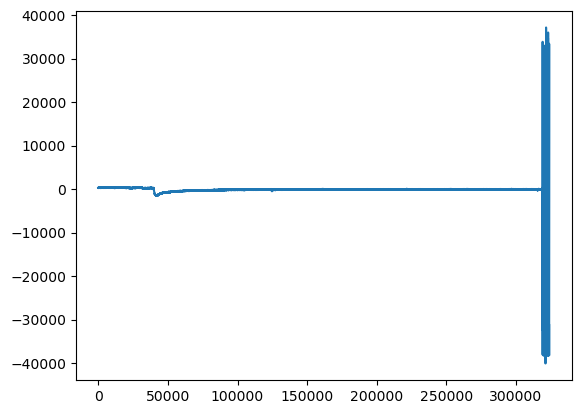

In [124]:
# All data quick visualization
CLFP_all
plt.plot(pre_raw)

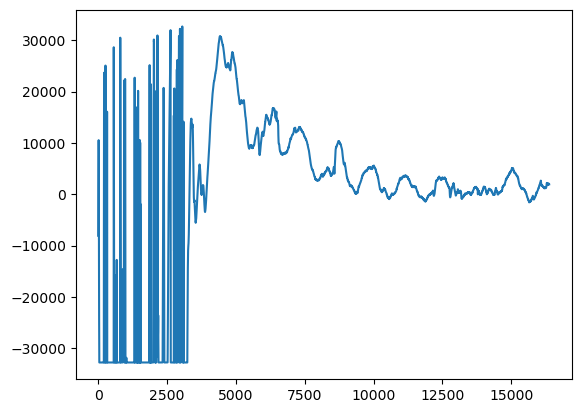

In [9]:
# single data file examination
mat_file = scipy.io.loadmat(mat_files[4])
CLFP_01 = mat_file['CLFP_01']
plt.plot(CLFP_01[0,:])

# Power spectral
This code block generate power spectral for each individual recording session for quick visualization of the session quality.


NOTES:
- There seems to be a harware filter at 60 hz, no peak signal at 60 hz from the power spectral graph.
- Need to ask all the hardware filter that has been applied to the raw data. 

In [87]:
# Import spectral power functions
from neurodsp.spectral import compute_spectrum, rotate_powerlaw

In [88]:
#plot for each file 
freq_list = []
psd_list = []

for m in mat_files:
    file = scipy.io.loadmat(m)
    CLFP_01 = file['CRAW_01'].flatten()
    CLFP_hz = file['CRAW_01_KHz'].flatten()*1000
    freq_mean, psd_mean = compute_spectrum(CLFP_01, CLFP_hz, method='welch', avg_type='mean', nperseg=CLFP_hz*2)

    #subset the frequence range below 120 hz
    new_freq = freq_mean[freq_mean<120]
    new_psd = psd_mean[freq_mean<120]
    freq_list.append(new_freq)
    psd_list.append(new_psd)


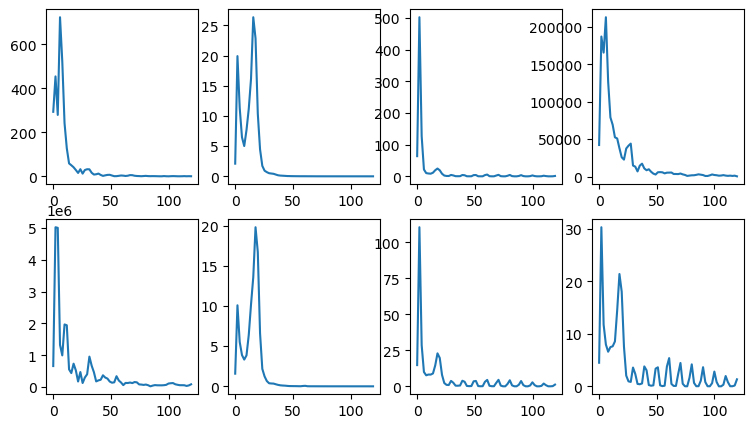

In [89]:
f, ax = plt.subplots(2,4, figsize=(9,5))

ax[0,0].plot(freq_list[0], psd_list[0])
ax[0,1].plot(freq_list[1], psd_list[1])
ax[0,2].plot(freq_list[2], psd_list[2])
ax[0,3].plot(freq_list[3], psd_list[3])

ax[1,0].plot(freq_list[4], psd_list[4])
ax[1,1].plot(freq_list[5], psd_list[5])
ax[1,2].plot(freq_list[6], psd_list[6])
ax[1,3].plot(freq_list[7], psd_list[7])

# Pre-processing IIR filtering

Note:
- bandstop, exclusion.
- bandpass, inclusion. 

In [90]:
# Pre-processing: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/filt/plot_3_IIR.html?highlight=line%20noise
from neurodsp.filt import filter_signal

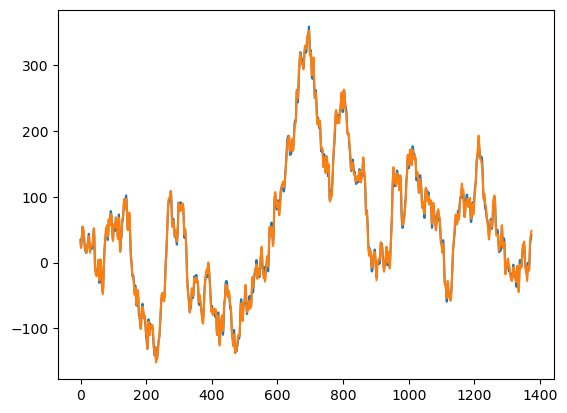

In [19]:
#filtering test for CLFP
f_range = (58, 62)
sig_filt = filter_signal(CLFP_all, CLFP_hz, 'bandstop', f_range,
                         filter_type='iir', butterworth_order=3)

# Plot filtered signal for the first 1 second
plt.plot(sig_filt[0:1375]) #filtered
plt.plot(CLFP_all[0:1375]) #raw

c:\Users\fuq01\Anaconda3\envs\LFPAnalysis\Lib\site-packages\neurodsp\filt\filter.py:98: UserWarning: Edge artifacts are not removed when using an IIR filter.
  warn('Edge artifacts are not removed when using an IIR filter.')


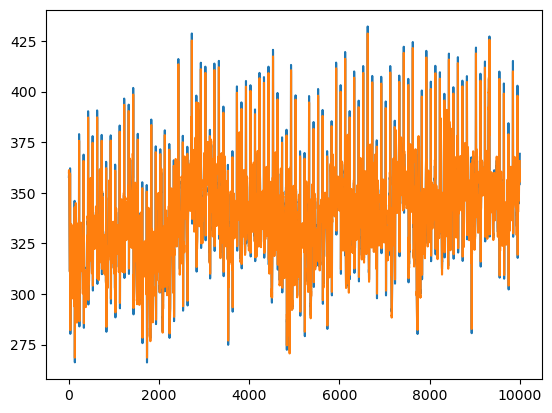

In [125]:
#filtering test for Raw data
f_range = (58, 62)
sig_filt = filter_signal(pre_raw, 1000, 'bandstop', f_range,
                         filter_type='iir', butterworth_order=3)

# Plot filtered signal for the first 1 second
# plt.plot(sig_filt[0:10000]) #filtered
plt.plot(pre_raw[0:10000]) #raw
plt.plot(sig_filt[0:10000]) #filtered

In [ ]:
# # tutorial testing

# from neurodsp.filt.iir import design_iir_filter, apply_iir_filter
# from neurodsp.filt.utils import compute_frequency_response, compute_transition_band
# Import plotting functions
# from neurodsp.plts import plot_frequency_response, plot_time_series

# n_seconds = 1
# fs = 1000

# # Define filter settings
# pass_type = 'bandstop'
# f_range = (58, 62) #freq range to filter out
# butterworth_order = 12

# # Design the filter, getting the second-order series (sos) values for the filter
# sos = design_iir_filter(fs, pass_type, f_range, butterworth_order)

# # Compute the frequency response for the IIR filter
# f_db, db = compute_frequency_response(sos, None, fs)

# # Plot the frequency response
# plot_frequency_response(f_db, db)

In [ ]:
# note for visualization 
# ax.set_xticklabels(np.round(new_freqs[np.linspace(0, len(new_freqs)-1, 6).astype(int)]))
# np.round(freq_mean[np.linspace(0, len(freq_mean)-1, 6).astype(int)])

# FOOOF  
- https://fooof-tools.github.io/fooof/
- https://github.com/valentinealissa/FOOOFy 

In [20]:
# Import the FOOOF object
from fooof import FOOOF


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 32 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offs

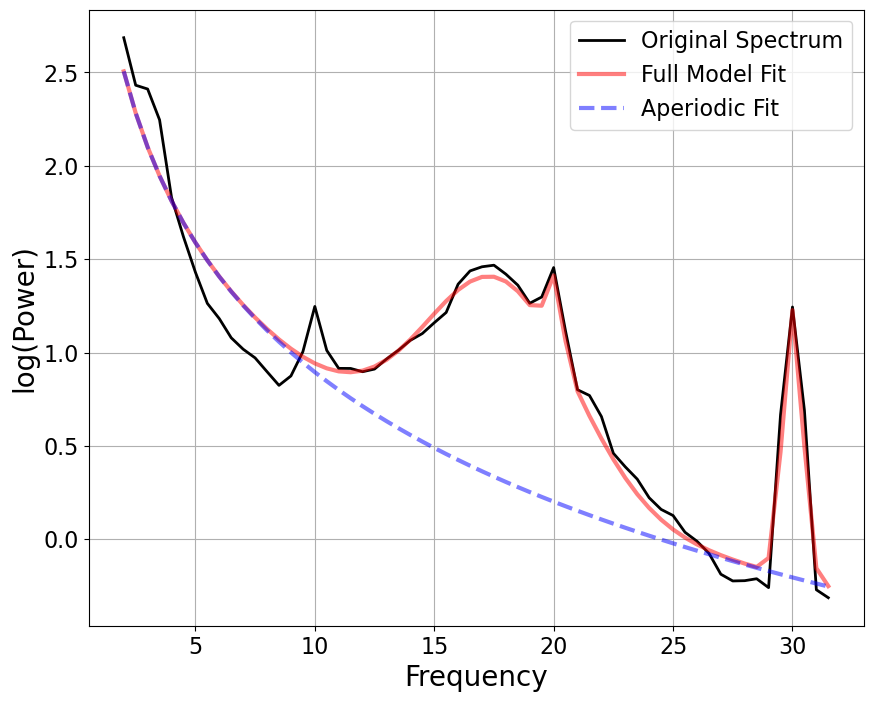

In [25]:
# Recording sessino 3: putative pre-op

# Initialize FOOOF object
fm = FOOOF()

# Define frequency range across which to model the spectrum
freq_range = [2, 32]

# Model the power spectrum with FOOOF, and print out a report
fm.report(freq_list[2], psd_list[2], freq_range)


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 32 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offs

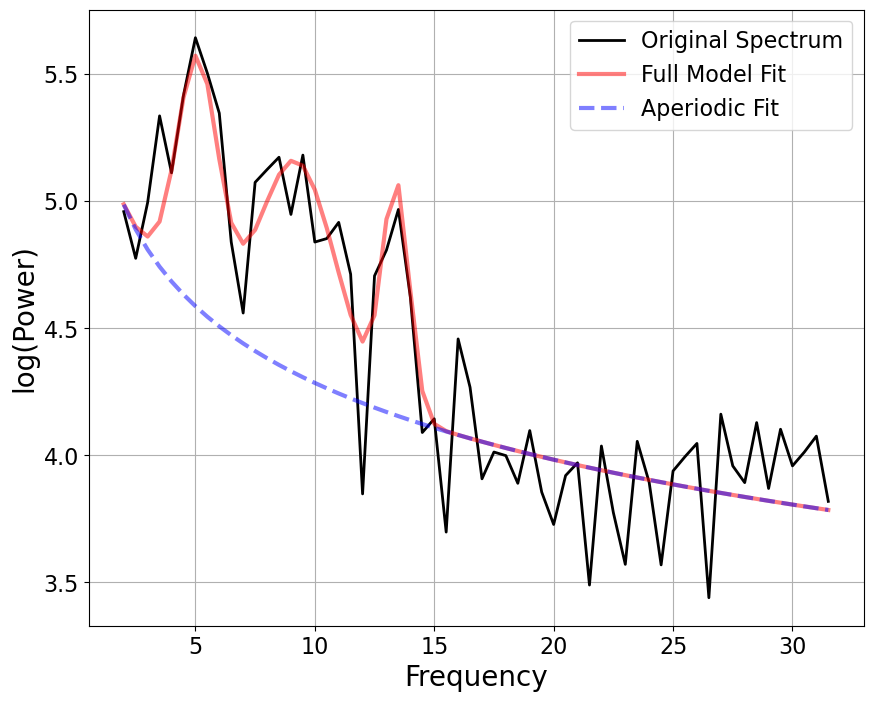

In [26]:
# Recording sessino 4: putative post-op

# nitialize FOOOF object
fm = FOOOF()
# Define frequency range across which to model the spectrum
freq_range = [2, 32] #beta edge

# Model the power spectrum with FOOOF, and print out a report
fm.report(freq_list[3], psd_list[3], freq_range)